# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from run_HIVAE import train_HIVAE, generate_from_HIVAE
from utils import data_processing, visualization

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
aids_control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
aids_control = pd.read_csv(data_file_control, header=None, names=aids_control_fnames)
print(aids_control.head())

   time  censor  strat2  sex  raceth  ivdrug  karnof    cd4  priorzdv  age
0   189       0       1    1       1       0     100  169.0      39.0   34
1   287       0       1    2       2       0      90  149.5      15.0   34
2   199       0       1    1       1       0      90   46.0      53.0   48
3   270       0       1    1       2       0     100   54.5       6.0   51
4   276       0       1    1       1       0     100   95.0       7.0   34


In [4]:
# Load and transform control data
data_init_control, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_transformed_control = data_processing.discrete_variables_transformation(data_init_control, feat_types_dict)

# Load and transform treated data
data_init_treated, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_transformed_treated = data_processing.discrete_variables_transformation(data_init_treated, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_transformed_treated = pd.DataFrame(data_init_transformed_treated.numpy(), columns=aids_control_fnames)
df_init_transformed_control = pd.DataFrame(data_init_transformed_control.numpy(), columns=aids_control_fnames)

# Update dataframe
df_init_transformed_treated["treatment"] = 1
df_init_transformed_control["treatment"] = 0
df_init_transformed = pd.concat([df_init_transformed_control, df_init_transformed_treated], ignore_index=True)

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [7]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE" : surv_hivae, 
                   "Surv-GAN" : surv_gan, 
                   "Surv-VAE" : surv_vae}

In [8]:
# the datasets used for training is data_init_control
n_generated_sample = 100

generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]
data_gen_transformed_control_dict = {}
for generator_name in generators_sel:
    if generator_name in ["HI-VAE"]:
        data_gen_transformed_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, miss_mask_control, true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample)
    else:
        data_gen_transformed_control_dict[generator_name] = generators_dict[generator_name].run(data_init_transformed_control, columns=aids_control_fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_sample)

Epoch: [ 0]  time: 0.0857, ELBO_train: -21.67301331, KL_z: 1.34363027, KL_s: 0.07224951, reconstruction loss: -20.25713353
Epoch: [100]  time: 2.7618, ELBO_train: -17.59379005, KL_z: 0.61200782, KL_s: 0.04001622, reconstruction loss: -16.94176601
Epoch: [200]  time: 5.2572, ELBO_train: -17.33025093, KL_z: 0.78408750, KL_s: 0.02940764, reconstruction loss: -16.51675578
Epoch: [300]  time: 7.8277, ELBO_train: -17.38994522, KL_z: 0.86447423, KL_s: 0.03139873, reconstruction loss: -16.49407227
Epoch: [400]  time: 10.4275, ELBO_train: -17.39502487, KL_z: 0.94462371, KL_s: 0.03799486, reconstruction loss: -16.41240630
Training finished.


[2025-04-28T17:15:00.417239+0200][47048][CRITICAL] load failed: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.
[2025-04-28T17:15:00.417753+0200][47048][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-04-28T17:15:00.417909+0200][47048][CRITICAL] module plugin_great load failed
[2025-04-28T17:15:00.435945+0200][47048][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [10]:
# Convert generated data into dataframe
df_gen_transformed_control_dict = {}
for generator_name in generators_sel:
    list_df_gen_transformed_control = []
    for j in range(n_generated_sample):
        df_gen_transformed_control_j = pd.DataFrame(data_gen_transformed_control_dict[generator_name][j].numpy(), columns=aids_control_fnames)
        df_gen_transformed_control_j['treatment'] = 0
        list_df_gen_transformed_control.append(df_gen_transformed_control_j)
        
    df_gen_transformed_control_dict[generator_name] = list_df_gen_transformed_control

### 3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [12]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

def synthcity_metrics(data_init, data_gen, generator):

    synthcity_dataloader_init = SurvivalAnalysisDataLoader(data_init, target_column = "censor", time_to_event_column = "time")
    scores = []
    for j in range(n_generated_sample):
        enable_reproducible_results(j)
        clear_cache()
        synthcity_dataloader_syn = SurvivalAnalysisDataLoader(data_gen[j], 
                                        target_column = "censor", 
                                        time_to_event_column = "time")

        evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                        X_syn=synthcity_dataloader_syn, 
                                        reduction='mean', # default mean
                                        n_histogram_bins=10, # default 10
                                        metrics=None, # all metrics
                                        task_type='survival_analysis', 
                                        use_cache=True)

        scores.append(evaluation.T[["stats.jensenshannon_dist.marginal", "stats.ks_test.marginal", 
                                    "stats.survival_km_distance.optimism", "detection.detection_xgb.mean", 
                                    "sanity.nearest_syn_neighbor_distance.mean", "privacy.k-map.score"]].T["mean"].values)

    score_df = pd.DataFrame(scores, columns=["J-S distance", "KS test", "Survival curves distance", 
                                             "Detection XGB", "NNDR", "K-map score"])
    score_df["generator"] = generator

    return score_df

In [13]:
scores = []
for generator_name in generators_sel:
    scores.append(synthcity_metrics(df_init_transformed_control, df_gen_transformed_control_dict[generator_name], generator_name))
scores_df = pd.concat(scores)

#### 3.1. Data resemblance

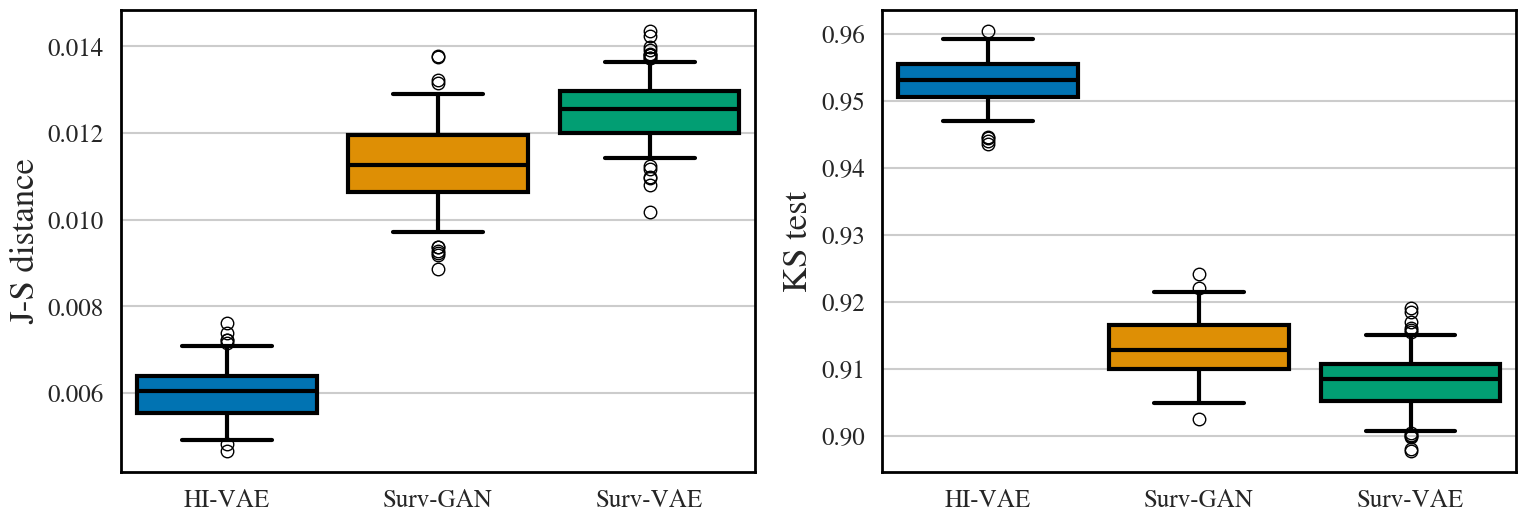

In [36]:
import seaborn as sns
sns.set(style='whitegrid',font="STIXGeneral",context='talk')

f, axs = plt.subplots(1, 2, figsize=(18,6))
[x.set_linewidth(2) for x in axs[0].spines.values()]
[x.set_edgecolor('black') for x in axs[0].spines.values()]
[x.set_linewidth(2) for x in axs[1].spines.values()]
[x.set_edgecolor('black') for x in axs[1].spines.values()]

metric = 'J-S distance'
plot = sns.boxplot(data=scores_df, x='generator', y=metric, ax=axs[0],
                    linewidth = 3, saturation = 1,
                    palette = 'colorblind', width = 1,
                    gap = 0.15, whis = 0.8, linecolor="Black")
xlabels = axs[0].get_xticklabels()
ylabels = axs[0].get_yticklabels()
axs[0].set_xticklabels(xlabels, size=18)
axs[0].set_yticklabels(ylabels, size=18)
axs[0].set_xlabel('')
axs[0].set_ylabel(metric, size=25)


metric = 'KS test'
plot = sns.boxplot(data=scores_df, x='generator', y=metric, ax=axs[1],
                    linewidth = 3, saturation = 1,
                    palette = 'colorblind', width = 1,
                    gap = 0.15, whis = 0.8, linecolor="Black")

xlabels = axs[1].get_xticklabels()
ylabels = axs[1].get_yticklabels()
axs[1].set_xticklabels(xlabels, size=18)
axs[1].set_yticklabels(ylabels, size=18)
axs[1].set_xlabel('')
axs[1].set_ylabel(metric, size=25)

plt.show()

#### 3.2 Utility

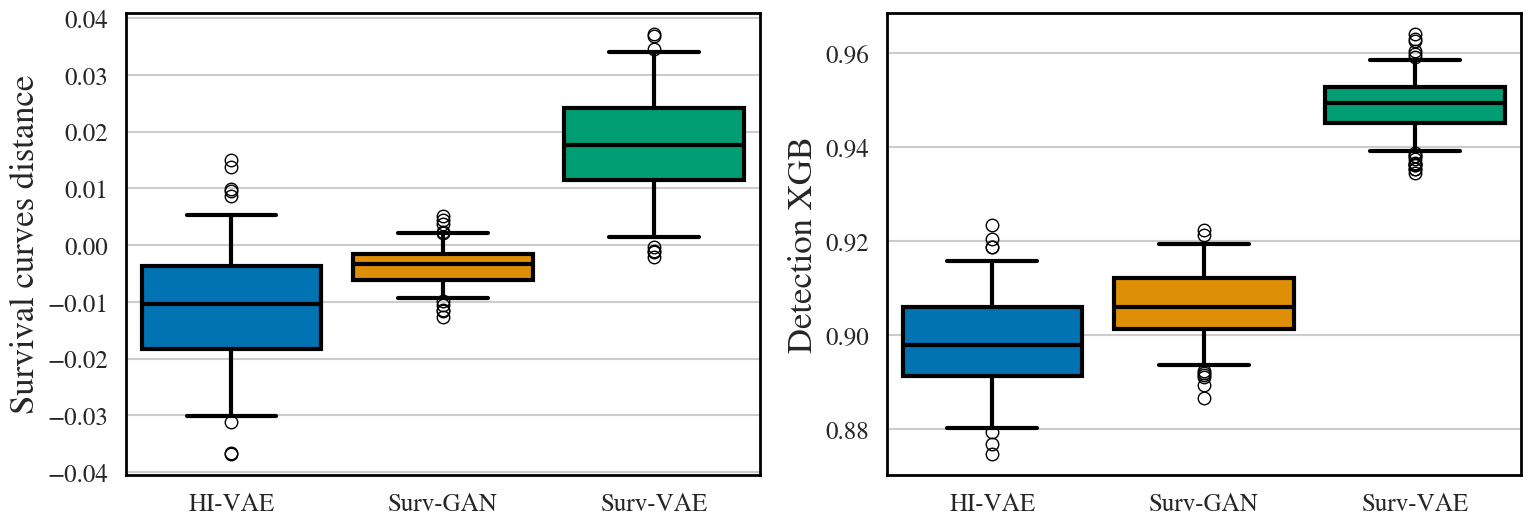

In [37]:
f, axs = plt.subplots(1, 2, figsize=(18,6))
[x.set_linewidth(2) for x in axs[0].spines.values()]
[x.set_edgecolor('black') for x in axs[0].spines.values()]
[x.set_linewidth(2) for x in axs[1].spines.values()]
[x.set_edgecolor('black') for x in axs[1].spines.values()]

metric = 'Survival curves distance'
plot = sns.boxplot(data=scores_df, x='generator', y=metric, ax=axs[0],
                    linewidth = 3, saturation = 1,
                    palette = 'colorblind', width = 1,
                    gap = 0.15, whis = 0.8, linecolor="Black")
xlabels = axs[0].get_xticklabels()
ylabels = axs[0].get_yticklabels()
axs[0].set_xticklabels(xlabels, size=18)
axs[0].set_yticklabels(ylabels, size=18)
axs[0].set_xlabel('')
axs[0].set_ylabel(metric, size=25)


metric = 'Detection XGB'
plot = sns.boxplot(data=scores_df, x='generator', y=metric, ax=axs[1],
                    linewidth = 3, saturation = 1,
                    palette = 'colorblind', width = 1,
                    gap = 0.15, whis = 0.8, linecolor="Black")

xlabels = axs[1].get_xticklabels()
ylabels = axs[1].get_yticklabels()
axs[1].set_xticklabels(xlabels, size=18)
axs[1].set_yticklabels(ylabels, size=18)
axs[1].set_xlabel('')
axs[1].set_ylabel(metric, size=25)

plt.show() 

#### 3.3 Privacy

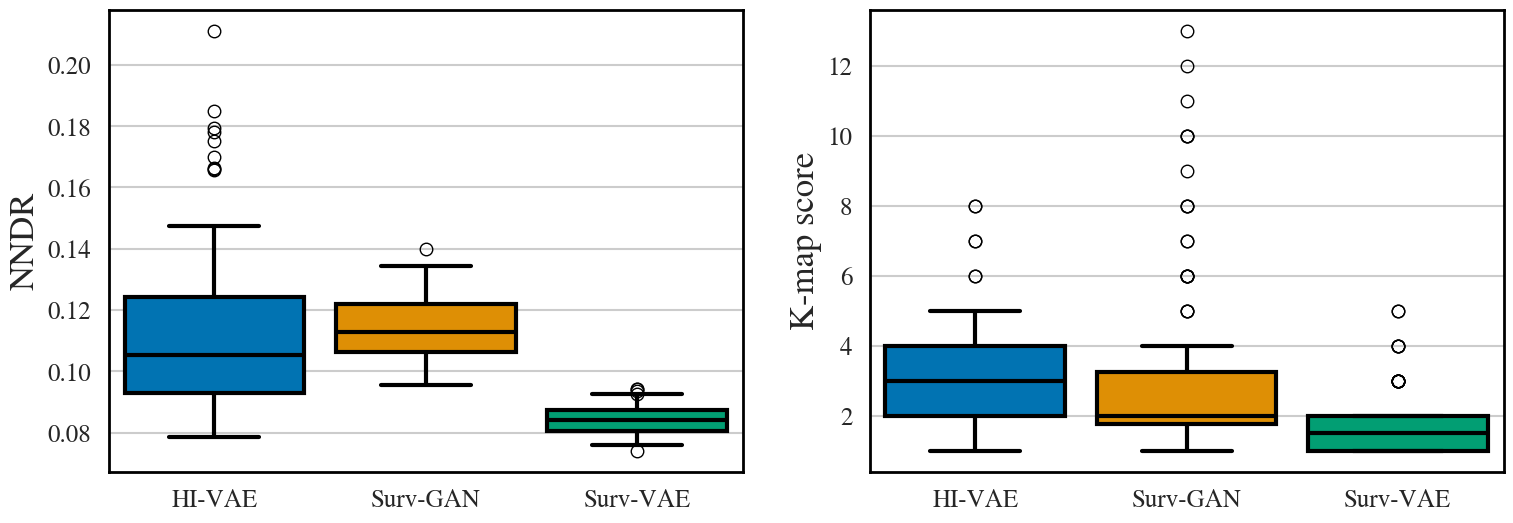

In [38]:
f, axs = plt.subplots(1, 2, figsize=(18,6))
[x.set_linewidth(2) for x in axs[0].spines.values()]
[x.set_edgecolor('black') for x in axs[0].spines.values()]
[x.set_linewidth(2) for x in axs[1].spines.values()]
[x.set_edgecolor('black') for x in axs[1].spines.values()]

metric = 'NNDR'
plot = sns.boxplot(data=scores_df, x='generator', y=metric, ax=axs[0],
                    linewidth = 3, saturation = 1,
                    palette = 'colorblind', width = 1,
                    gap = 0.15, whis = 0.8, linecolor="Black")
xlabels = axs[0].get_xticklabels()
ylabels = axs[0].get_yticklabels()
axs[0].set_xticklabels(xlabels, size=18)
axs[0].set_yticklabels(ylabels, size=18)
axs[0].set_xlabel('')
axs[0].set_ylabel(metric, size=25)


metric = 'K-map score'
plot = sns.boxplot(data=scores_df, x='generator', y=metric, ax=axs[1],
                    linewidth = 3, saturation = 1,
                    palette = 'colorblind', width = 1,
                    gap = 0.15, whis = 0.8, linecolor="Black")

xlabels = axs[1].get_xticklabels()
ylabels = axs[1].get_yticklabels()
axs[1].set_xticklabels(xlabels, size=18)
axs[1].set_yticklabels(ylabels, size=18)
axs[1].set_xlabel('')
axs[1].set_ylabel(metric, size=25)

plt.show()